In [ ]:
!pip install -qq transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from html.parser import HTMLParser
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Daris
#os.chdir('/content/drive/My Drive/repo-ML_handson')
#Nico
os.chdir('/content/drive/My Drive/Colab Notebooks/ML-hands_on/repo-ML_handson')

In [ ]:
test_drug = pd.read_csv('./data/raw/Drug_DB/drugsComTest_raw.tsv', sep = '\t')
train_drug = pd.read_csv('./data/raw/Drug_DB/drugsComTrain_raw.tsv', sep = '\t')

In [ ]:
# This is filter for HTML syntax.
class HTMLFilter(HTMLParser):
  """Class used to transform the HTML syntax into text characters."""
    text = ""
    def handle_data(self, data):
        self.text += data

    def strip_tags(html):
        f = HTMLFilter()
        f.feed(html)
        return f.text

In [ ]:
train_drug['review_processed'] = train_drug.review.apply(HTMLFilter.strip_tags)
test_drug['review_processed'] = test_drug.review.apply(HTMLFilter.strip_tags)
train_drug.drop(columns = 'review', inplace = True)
test_drug.drop(columns = 'review', inplace = True)

In [ ]:
def add_class_rating(df, df_column):
  """Returns columns with satisfaction class score with:
    0 --> negative
    1 --> neutral
    2 --> positive

    Key arguments:
      df --> pandas dataframe
      df_column --> raiting column from df.
  """
  class_raiting = []
  for r in df[df_column]:
      if r < 4:
          class_raiting.append(0)
      if 4 <= r <= 6:
          class_raiting.append(1)
      if r > 6:
          class_raiting.append(2)
  return class_raiting

In [ ]:
# labeling creation
y_test = add_class_rating(test_drug, 'rating')


In [ ]:
y_train = add_class_rating(train_drug, 'rating')

In [ ]:
train_drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        161297 non-null  int64  
 1   drugName          161297 non-null  object 
 2   condition         160398 non-null  object 
 3   rating            161297 non-null  float64
 4   date              161297 non-null  object 
 5   usefulCount       161297 non-null  int64  
 6   review_processed  161297 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


In [ ]:
train_drug.shape

(161297, 7)

There are some missing values in the condition column but we decided to not take care of those since this feature is not relevant for today's work. We will rely on Rating and review columns.

In [ ]:
g = train_drug.groupby(by=y_train)

In [ ]:
positive = g.get_group(2).sample(1000)
negative = g.get_group(0).sample(1000)
neutral = g.get_group(1).sample(1000)

In [ ]:
trimmed_train_drug = pd.concat([positive, negative, neutral])

In [ ]:
#trimmed_train_drug.to_csv('/content/drive/My Drive/repo-ML_handson/data/processed/trim_drugsComTest_raw.tsv', index=False, sep='\t')

Due to PC limitations, we decided to trim the train dataset in order to be able to make the modelling. In this case we picked randomly 1000 samples of each sentiment so the final dataset has 3000 samples.

In [ ]:
trimmed_train_drug = pd.read_csv('./data/processed/trim_drugsComTest_raw.tsv', sep = '\t')

In [ ]:
y_trim_train = add_class_rating(trimmed_train_drug, 'rating')

Text(0.5, 0.98, 'Sentiments and rating distribution')

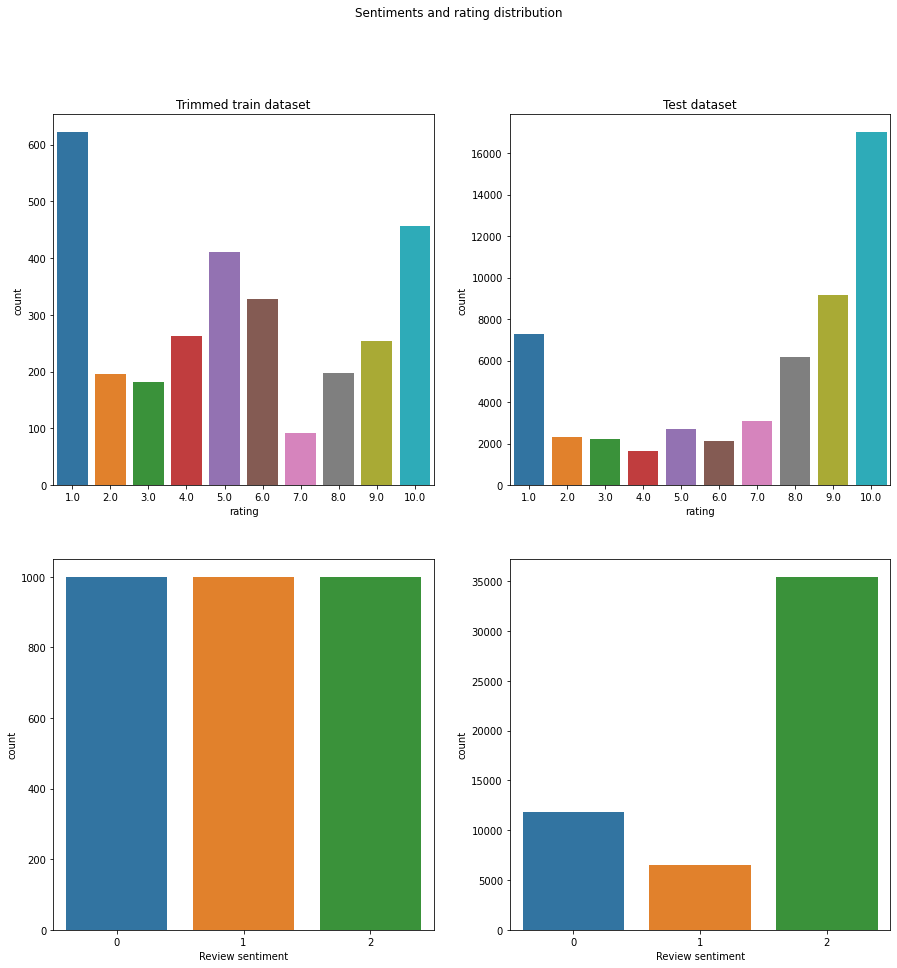

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
sns.countplot(trimmed_train_drug.rating, ax = axes[0, 0])
axes[0, 0].set_title('Trimmed train dataset')
sns.countplot(test_drug.rating, ax = axes[0, 1])
axes[0, 1].set_title('Test dataset')
sns.countplot(y_trim_train, ax = axes[1, 0])
axes[1, 0].set_xlabel('Review sentiment')
sns.countplot(y_test, ax = axes[1, 1])
axes[1, 1].set_xlabel('Review sentiment')
fig.suptitle('Sentiments and rating distribution')

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
token_lens = []
for txt in trimmed_train_drug.review_processed:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

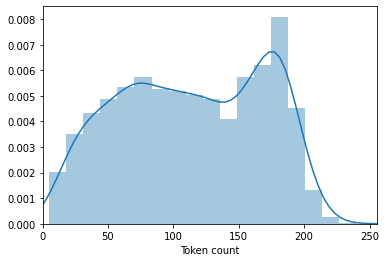

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

As we can see in the Token distribution, most of the tokens have a length less than 200, therefore we pick the max length to be 200.

In [ ]:
MAX_LEN = 200

In [ ]:
class GPReviewDataset(Dataset):
  """Class containing all building blocks to generate a PyTorch dataset from the reviews (text) into tensors (numerical arrays).
  """
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# spliting the trimmed training dataset into train and validation dataset in an 80/20 relation.
df_train, df_val, y_train, y_val = train_test_split(
  trimmed_train_drug, y_trim_train,
  test_size = 0.2,
  random_state=RANDOM_SEED
)

In [ ]:
# merging the datasets with their labeling array to use it during the model training.
test_drug['sentiment'] = y_test
df_test = test_drug
df_train['sentiment'] = y_train
df_val['sentiment'] = y_val

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  """Returns a Data loader used to feed the model.
  """
  ds = GPReviewDataset(
    reviews=df.review_processed.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
# creating data loaders from the three datasets with a batch size of 16 following BERT original paper recomendations.
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SentimentClassifier(nn.Module):
  """Class used to define Sentiment classifier model."""
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False) # AdamW optimizer as suggested in BERT paper.
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
"""Function used to train one epoch of Sentiment model and returns predicted accuracy and mean of loss."""
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  """Function used to evaluate one epoch of Sentiment model and returns predicted accuracy and mean of loss."""
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Training the model, each epoch accuracy and loss is printed during the model training.
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.0262779267628988 accuracy 0.44875000000000004
Val   loss 0.840275416248723 accuracy 0.6216666666666667

Epoch 2/10
----------
Train loss 0.7466152383883794 accuracy 0.6637500000000001
Val   loss 0.8463787020821321 accuracy 0.6466666666666667

Epoch 3/10
----------
Train loss 0.5328502479195595 accuracy 0.7783333333333334
Val   loss 1.1092106903854169 accuracy 0.5466666666666667

Epoch 4/10
----------
Train loss 0.3114862540985147 accuracy 0.8875000000000001
Val   loss 1.4271073231571598 accuracy 0.5866666666666667

Epoch 5/10
----------
Train loss 0.1648235007872184 accuracy 0.9508333333333334
Val   loss 1.6676377183512638 accuracy 0.6333333333333334

Epoch 6/10
----------
Train loss 0.1247122183504204 accuracy 0.9633333333333334
Val   loss 1.8439674534295734 accuracy 0.6383333333333334

Epoch 7/10
----------
Train loss 0.07345083762581149 accuracy 0.9825
Val   loss 2.0568987060534325 accuracy 0.6466666666666667

Epoch 8/10
----------
Train loss 0.041

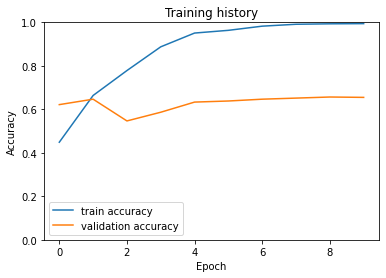

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.6668340586988059

After making the model traning we can see on the plot that there is a training overfitting and a low validation accuracy. This results are reliable since the training dataset used was balanced (same number of samples of each sentiment) suggesting that a parameter tuning would be needed. 

In [ ]:
def get_predictions(model, data_loader):
  """Function used to predict test dataaset with trained sentiment model."""
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.74      0.58      0.65     11838
     neutral       0.24      0.68      0.35      6488
    positive       0.95      0.69      0.80     35440

    accuracy                           0.67     53766
   macro avg       0.64      0.65      0.60     53766
weighted avg       0.82      0.67      0.71     53766



After doing the model prediction over the test dataset, the f1-scores are:
- Negative: 0.65
- Neutral: 0.35
- Positive: 0.80

This results showed a good model performance for positive sentiment, a satisfactory for negative sentiment and low performance for the neutral sentiment.

This first result gives us an insight of possible measures that could be taken into account to build a better model.

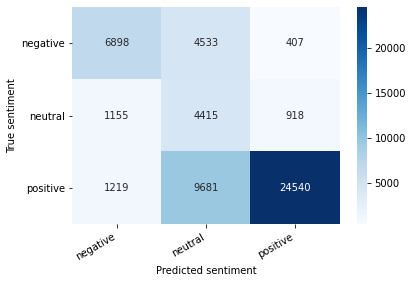

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

The confusion matrix confirms the results obtained in the f1-score estimation, with a poor performance por neutral sentiments. One possible solution would be to train a new model with more samples in general but also focusing on increasing the nuetral sentiments samples and another possible option would be to do a parameter tuning with the validation dataset to get the best possible model.

Due to time and computer resourses limitations we were not able to implement these options stated above.

